In [45]:
library(tidyverse)
library(car)
library(glmnet)

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1-8



In [5]:
# read data
data = read.csv('everything.csv', header = TRUE, na.strings = '')
data$date <- as.Date(data$date)
data$date <- format(data$date, format = '%Y')

# grab my own columns (sh starts in 2010)
df <- data %>%
select(3, 5, 6, 25, 26, 27, 28, 29, 53)

# remove na rows (not relevant for my part)
df[df == 'NA'] <- NA
df <- df[complete.cases(df), ]

# make sure the numbers are numeric
df$Overall.Homeless = as.numeric(df$Overall.Homeless)
df$Sheltered.ES.Homeless = as.numeric(df$Sheltered.ES.Homeless)
df$Sheltered.TH.Homeless = as.numeric(df$Sheltered.TH.Homeless)
df$Sheltered.Total.Homeless = as.numeric(df$Sheltered.Total.Homeless)
df$Unsheltered.Homeless = as.numeric(df$Unsheltered.Homeless)
df$Sheltered.SH.Homeless = as.numeric(df$Sheltered.SH.Homeless)

# fix ZHVI into yearly (avg of years value)
# https://stackoverflow.com/questions/52221044/dplyrfirst-to-choose-first-non-na-value
df <- df %>%
group_by(RegionName, date) %>%
summarize(
    avg_ZHVI = mean(ZHVI, na.rm = TRUE),

    Overall.Homeless = first(na.omit(Overall.Homeless)),
    Sheltered.ES.Homeless = first(na.omit(Sheltered.ES.Homeless)),
    Sheltered.TH.Homeless = first(na.omit(Sheltered.TH.Homeless)),
    Sheltered.Total.Homeless = first(na.omit(Sheltered.Total.Homeless)),
    Unsheltered.Homeless = first(na.omit(Unsheltered.Homeless)),
    Sheltered.SH.Homeless = first(na.omit(Sheltered.SH.Homeless)),

    .groups = 'drop'
    )

- **RegionName**: State of residence (Qualitative)
- **Date**: Month/Year (Quantitative)
- **ZHVI**: Housing prices (Quantitative)
- **Overall.Homeless**: Total number of homeless (Quantitative)
- **Unsheltered.Homeless**: Total number of unsheltered homeless (Quantitative)
- **Sheltered.ES.Homeless**: Total number of Emergency Shelter (ES) homeless (Quantitative)
- **Sheltered.TH.Homeless**: Total number of Transitional Housing (TH) homeless (Quantitative)
- **Sheltered.SH.Homeless**: Total number of Safe Haven (SH) homeless

In [ ]:
# make sheltered into a categorical variable
homeless_df <- df %>%
pivot_longer(cols = c(Sheltered.ES.Homeless, Sheltered.TH.Homeless, Sheltered.SH.Homeless),
             names_to = 'Sheltered.Type',
             values_to = 'Sheltered.Type.Count')
# https://stackoverflow.com/questions/66736264/how-do-i-rename-values-of-a-variable-in-r
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Sheltered.ES.Homeless'] = 'ES'
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Sheltered.TH.Homeless'] = 'TH'
homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Sheltered.SH.Homeless'] = 'SH'
#homeless_df$Sheltered.Type[homeless_df$Sheltered.Type == 'Unsheltered.Homeless'] = 'US'

homeless_df$Sheltered.Type <- as.factor(homeless_df$Sheltered.Type)
head(homeless_df, 10)

#divide into train and test data
homeless_df$date = as.factor(homeless_df$date)

trainData <- homeless_df[homeless_df$date != '2023', ]
testData <- homeless_df[homeless_df$date == '2023', ]

In [ ]:
bar = xtabs(homeless_df$Sheltered.Type.Count ~ homeless_df$Sheltered.Type + homeless_df$date)
proportion <- prop.table(bar, margin = 2)

par(mar = c(6, 4, 4, 7))
barplot(proportion,
        main = 'Proportion of Homeless by Sheltered Type',
        col = rainbow(nrow(proportion)),
        legend.text = rownames(proportion),
        args.legend = list(x = 'topright', inset = c(-0.25, 0), bty = 'n', cex = 0.8),
        cex.names = 0.8,
        cex.axis = 0.8,
        las = 2)

In [100]:
trainData <- droplevels(trainData)
model1 <- lm(avg_ZHVI ~ RegionName + date + Unsheltered.Homeless + Sheltered.Type, data = trainData)
summary(model1)


Call:
lm(formula = avg_ZHVI ~ RegionName + date + Unsheltered.Homeless + 
    Sheltered.Type, data = trainData)

Residuals:
    Min      1Q  Median      3Q     Max 
-118946  -10724     -93   13838  158371 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           2.385e+05  5.464e+03  43.657  < 2e-16 ***
RegionNameAL         -1.376e+05  6.829e+03 -20.152  < 2e-16 ***
RegionNameAR         -1.473e+05  6.829e+03 -21.570  < 2e-16 ***
RegionNameAZ         -4.840e+04  6.853e+03  -7.063 2.29e-12 ***
RegionNameCA          1.440e+05  1.508e+04   9.547  < 2e-16 ***
RegionNameCO          4.590e+04  6.855e+03   6.695 2.84e-11 ***
RegionNameCT         -2.887e+04  6.827e+03  -4.228 2.47e-05 ***
RegionNameDE         -3.013e+04  6.827e+03  -4.413 1.07e-05 ***
RegionNameFL         -8.428e+04  7.608e+03 -11.078  < 2e-16 ***
RegionNameGA         -1.090e+05  6.907e+03 -15.775  < 2e-16 ***
RegionNameHI          2.639e+05  6.842e+03  38.563  < 2e-16 ***
RegionName

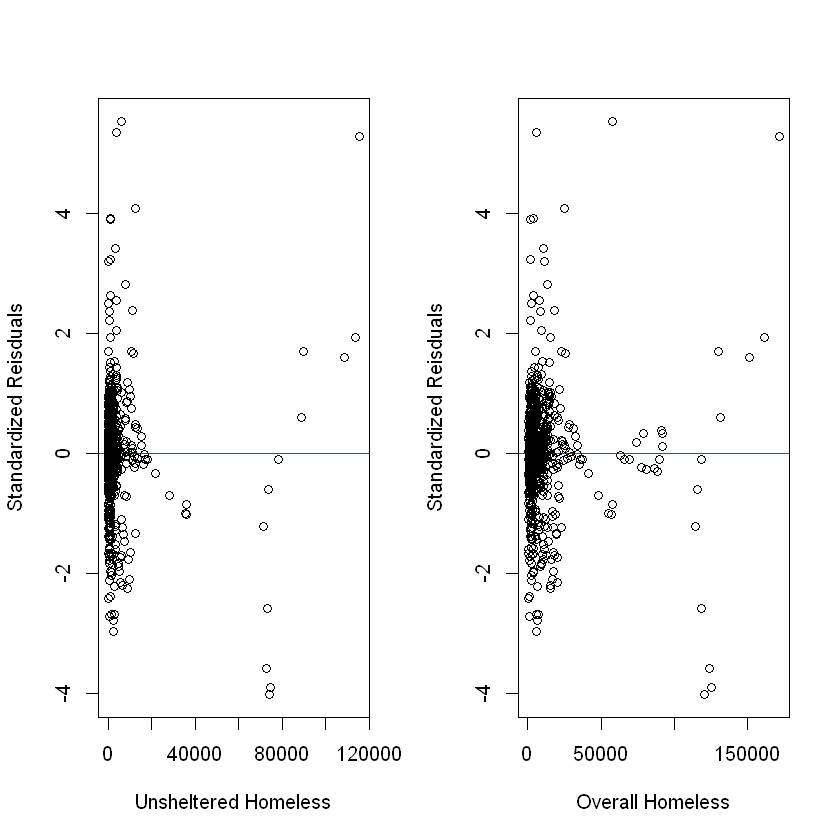

In [102]:
# linearity assumption
resids <- rstandard(model1)
par(mfrow = c(1, 2))
plot(trainData$Unsheltered.Homeless, resids,
     xlab = 'Unsheltered Homeless',
     ylab = 'Standardized Reisduals',
     abline(h = 0, col = 'red')
     )
plot(trainData$Overall.Homeless, resids,
     xlab = 'Overall Homeless',
     ylab = 'Standardized Reisduals',
     abline(h = 0, col = 'red')
     )

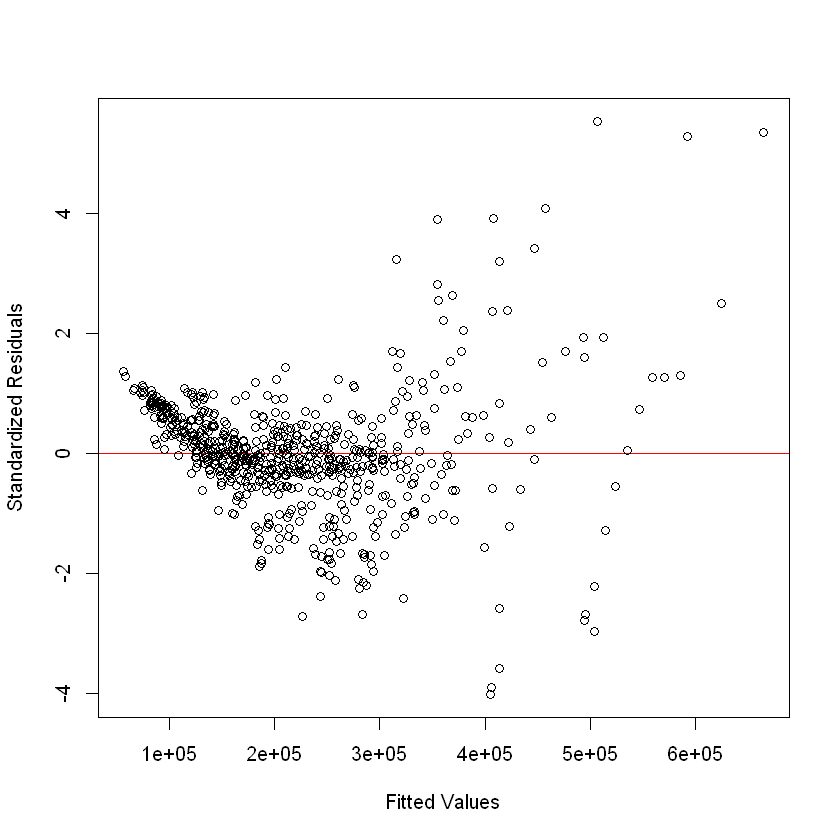

In [104]:
# constant variance assumption
plot(model1$fitted.values, resids,
     xlab = 'Fitted Values',
     ylab = 'Standardized Residuals',
     abline(h = 0, col = 'red')
     )

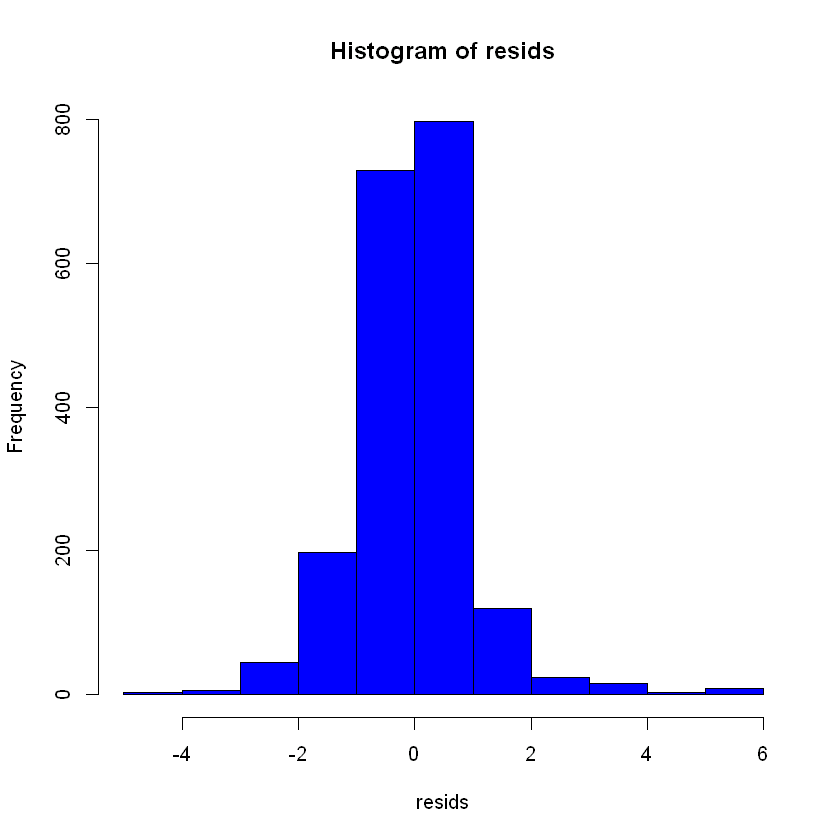

[1] 191 190

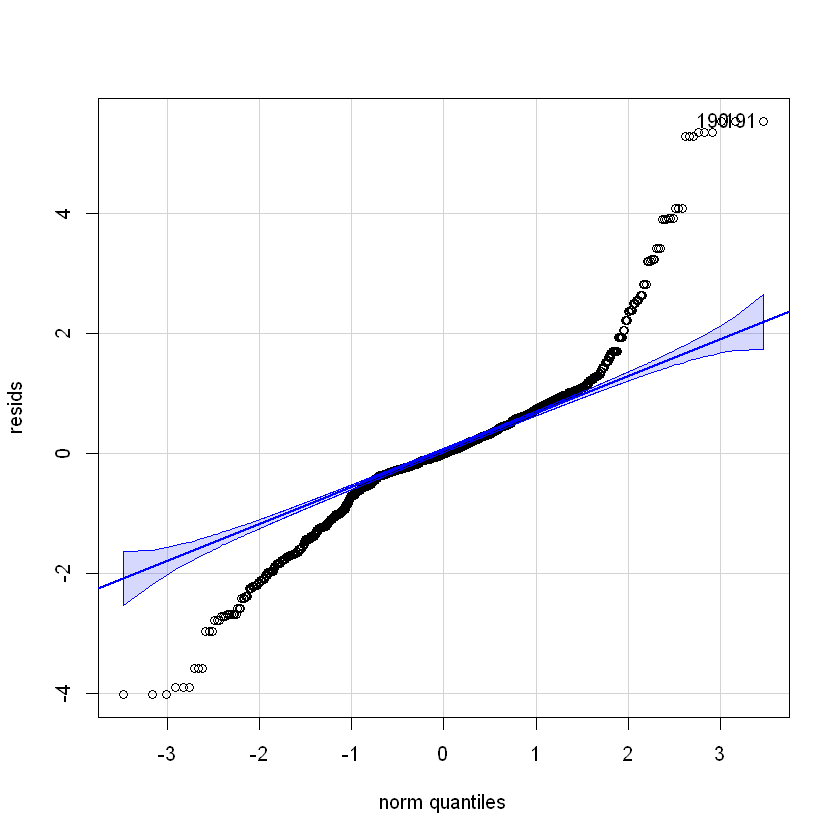

In [106]:
# normality assumption
hist(resids, col = 'blue')
qqPlot(resids, envelope = 0.95)

Second Part of my Analysis

In [7]:
# what if the sheltered type is not categorical dummy variable
train_new <- df[df$date != 2023, ]
test_new <- df[df$date == 2023, ]

model2 <- lm(avg_ZHVI ~ RegionName + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + Sheltered.SH.Homeless + Unsheltered.Homeless, data = train_new)
summary(model2)


Call:
lm(formula = avg_ZHVI ~ RegionName + Overall.Homeless + Sheltered.ES.Homeless + 
    Sheltered.TH.Homeless + Sheltered.SH.Homeless + Unsheltered.Homeless, 
    data = train_new)

Residuals:
    Min      1Q  Median      3Q     Max 
-116228  -21640   -6756   15196  239854 

Coefficients: (1 not defined because of singularities)
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            3.002e+05  1.300e+04  23.092  < 2e-16 ***
RegionNameAL          -1.110e+05  1.849e+04  -6.003 3.37e-09 ***
RegionNameAR          -1.470e+05  1.822e+04  -8.068 3.94e-15 ***
RegionNameAZ           2.961e+04  1.965e+04   1.507  0.13241    
RegionNameCA           7.643e+05  6.271e+04  12.188  < 2e-16 ***
RegionNameCO           1.325e+05  1.954e+04   6.781 2.88e-11 ***
RegionNameCT          -1.659e+04  1.828e+04  -0.908  0.36438    
RegionNameDE          -3.550e+04  1.822e+04  -1.948  0.05188 .  
RegionNameFL           1.690e+05  3.023e+04   5.589 3.49e-08 ***
RegionNameGA   

I tried to do another model with Unsheltered instead of Overall Homeless and again the model shows it gives multicollinearity and so does the NA. For the first model, with a threshold of 0.05 we would reject: Region CT, Region DE, Region GA, Region IL, Region MN, Region NC, Region NH, Region NV, Region PA, Region RI, Region UT, Region VA, Overall Homeless, Sheltered ES, Sheltered SH. As we can see aside from TH Homeless, none of the others are significant predictors. For the second model, it's the same thing. If I run the model with everything: RegionName, avg_ZHVI, Sheltered, Overall and Unsheltered, then it automatically decides Sheltered SH has multicollinearity and the rest of the homeless predictors are significant at a 0.1 level but not at a 0.05. 

In [10]:
#take out Unsheltered.Homeless
model3 <- lm(avg_ZHVI ~ RegionName + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + Sheltered.SH.Homeless, data = train_new)
summary(model3)


Call:
lm(formula = avg_ZHVI ~ RegionName + Overall.Homeless + Sheltered.ES.Homeless + 
    Sheltered.TH.Homeless + Sheltered.SH.Homeless, data = train_new)

Residuals:
    Min      1Q  Median      3Q     Max 
-116228  -21640   -6756   15196  239854 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            3.002e+05  1.300e+04  23.092  < 2e-16 ***
RegionNameAL          -1.110e+05  1.849e+04  -6.003 3.37e-09 ***
RegionNameAR          -1.470e+05  1.822e+04  -8.068 3.94e-15 ***
RegionNameAZ           2.961e+04  1.965e+04   1.507  0.13241    
RegionNameCA           7.643e+05  6.271e+04  12.188  < 2e-16 ***
RegionNameCO           1.325e+05  1.954e+04   6.781 2.88e-11 ***
RegionNameCT          -1.659e+04  1.828e+04  -0.908  0.36438    
RegionNameDE          -3.550e+04  1.822e+04  -1.948  0.05188 .  
RegionNameFL           1.690e+05  3.023e+04   5.589 3.49e-08 ***
RegionNameGA          -2.067e+04  1.940e+04  -1.066  0.28698    
RegionNameHI       

In [12]:
model4 <- lm(avg_ZHVI ~ RegionName + date + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + Sheltered.SH.Homeless, data = train_new)
summary(model4)


Call:
lm(formula = avg_ZHVI ~ RegionName + date + Unsheltered.Homeless + 
    Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless + 
    Sheltered.SH.Homeless, data = train_new)

Residuals:
   Min     1Q Median     3Q    Max 
-96033 -11472    492  12668 156103 

Coefficients: (1 not defined because of singularities)
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            257340.05    9183.25  28.023  < 2e-16 ***
RegionNameAL          -133161.19   11445.35 -11.635  < 2e-16 ***
RegionNameAR          -147045.92   11239.38 -13.083  < 2e-16 ***
RegionNameAZ           -32673.08   12379.68  -2.639 0.008531 ** 
RegionNameCA           286307.59   43564.78   6.572 1.10e-10 ***
RegionNameCO            66475.08   12346.86   5.384 1.06e-07 ***
RegionNameCT           -26880.18   11281.69  -2.383 0.017508 *  
RegionNameDE           -31746.80   11243.92  -2.823 0.004913 ** 
RegionNameFL           -32608.77   20376.58  -1.600 0.110071    
RegionNameGA      

In [14]:
#same as model3_copy but without Sheltered SH
model5 <- lm(avg_ZHVI ~ RegionName + date + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless, data = train_new)
summary(model5)


Call:
lm(formula = avg_ZHVI ~ RegionName + date + Unsheltered.Homeless + 
    Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless, 
    data = train_new)

Residuals:
   Min     1Q Median     3Q    Max 
-96033 -11472    492  12668 156103 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            257340.05    9183.25  28.023  < 2e-16 ***
RegionNameAL          -133161.19   11445.35 -11.635  < 2e-16 ***
RegionNameAR          -147045.92   11239.38 -13.083  < 2e-16 ***
RegionNameAZ           -32673.08   12379.68  -2.639 0.008531 ** 
RegionNameCA           286307.59   43564.78   6.572 1.10e-10 ***
RegionNameCO            66475.08   12346.86   5.384 1.06e-07 ***
RegionNameCT           -26880.18   11281.69  -2.383 0.017508 *  
RegionNameDE           -31746.80   11243.92  -2.823 0.004913 ** 
RegionNameFL           -32608.77   20376.58  -1.600 0.110071    
RegionNameGA           -83655.80   12246.84  -6.831 2.13e-11 ***
RegionNameHI      

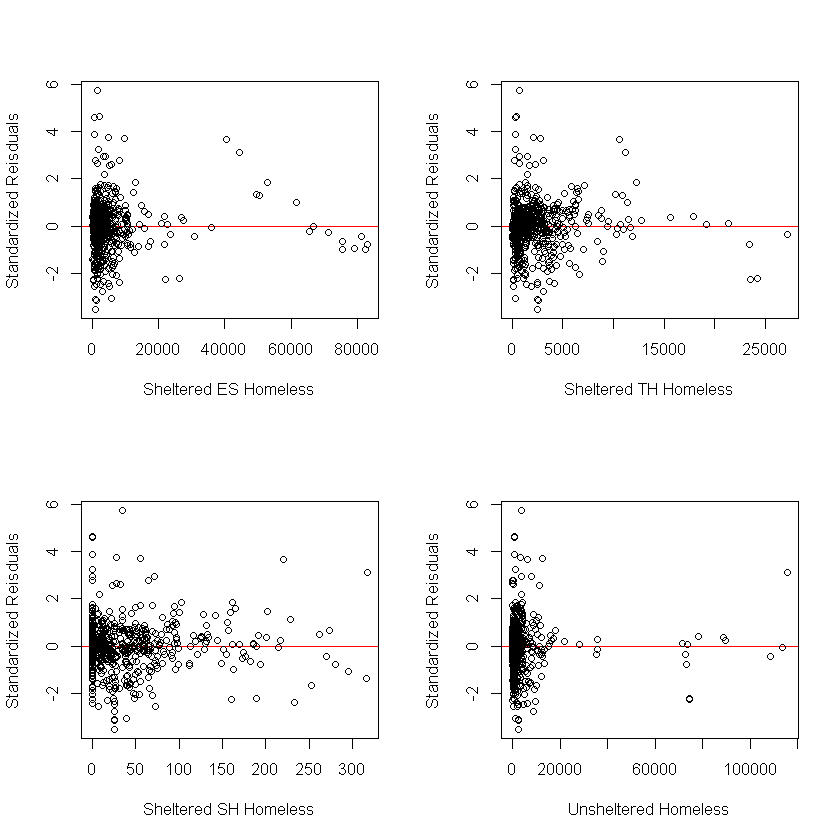

In [16]:
# linearity assumption
resids_copy <- rstandard(model5)
par(mfrow = c(2, 2))
plot(train_new$Sheltered.ES.Homeless, resids_copy,
     xlab = 'Sheltered ES Homeless',
     ylab = 'Standardized Reisduals',
     abline(h = 0, col = 'red')
     )
plot(train_new$Sheltered.TH.Homeless, resids_copy,
     xlab = 'Sheltered TH Homeless',
     ylab = 'Standardized Reisduals',
     abline(h = 0, col = 'red')
     )
plot(train_new$Sheltered.SH.Homeless, resids_copy,
     xlab = 'Sheltered SH Homeless',
     ylab = 'Standardized Reisduals',
     abline(h = 0, col = 'red')
     )
plot(train_new$Unsheltered.Homeless, resids_copy,
     xlab = 'Unsheltered Homeless',
     ylab = 'Standardized Reisduals',
     abline(h = 0, col = 'red')
     )

Linearity Assumption sticks around the y = 0 line for all predictors pretty evenly, yet for all of them they are concentrated to the left side of the plots. Therefore, the linearity assumption does not hold. 

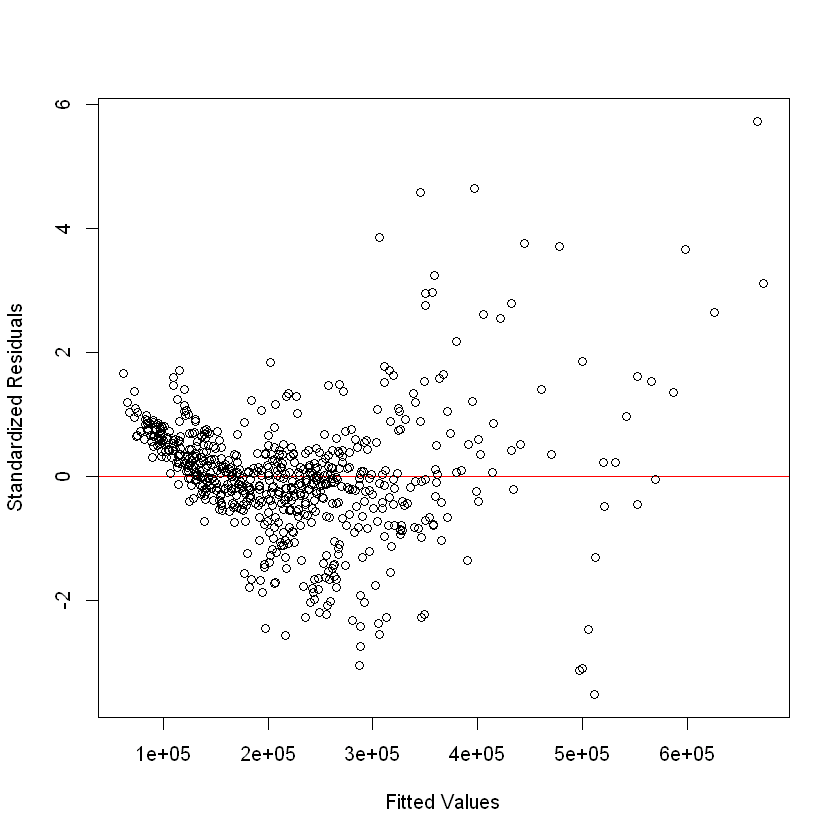

In [19]:
# constant variance assumption
plot(model5$fitted.values, resids_copy,
     xlab = 'Fitted Values',
     ylab = 'Standardized Residuals',
     abline(h = 0, col = 'red')
     )

Constant Variance assumption hold when the spread of residuals is consistent as fitted values change. Therefore, by looking at the graph above constant variance assumption des not hold. This is because as fitted values increase there are more standardized residuals above the y = 0 line. 

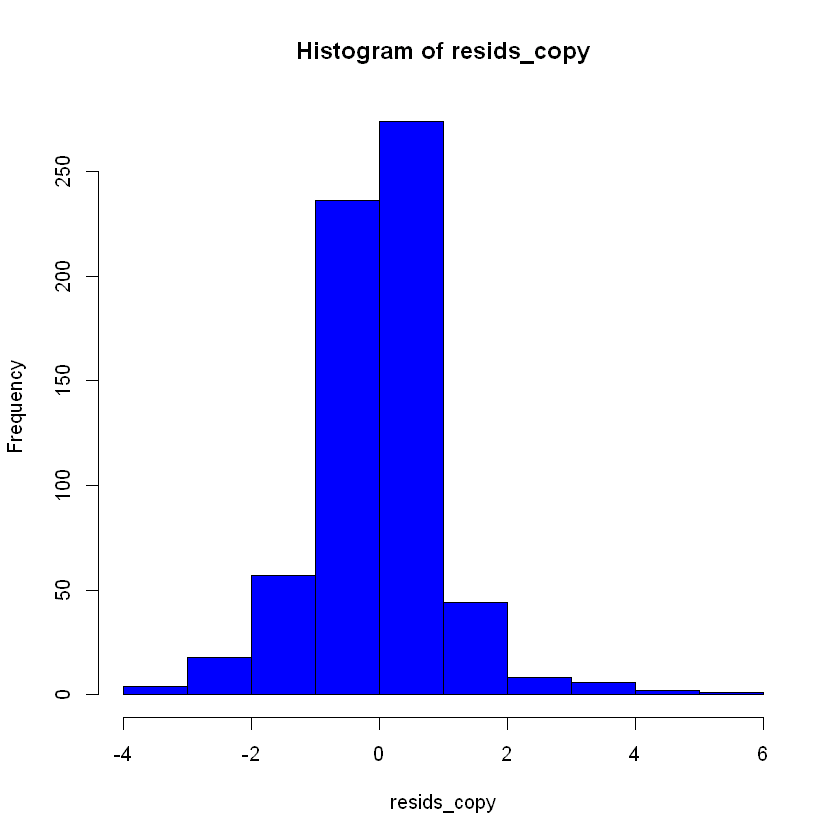

[1] 143 572

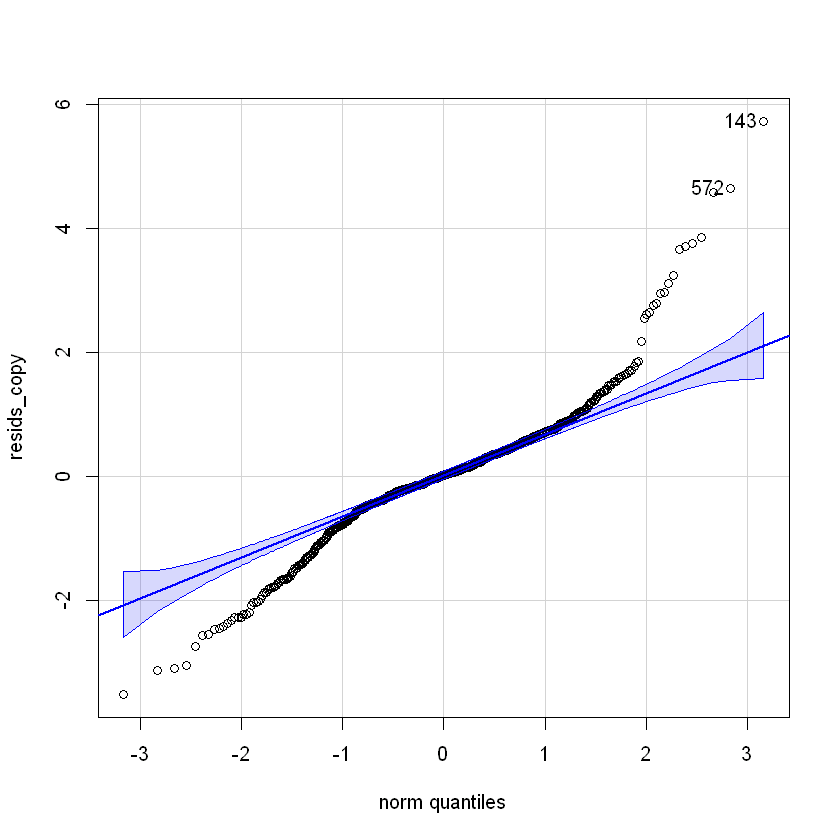

In [22]:
# normality assumption
hist(resids_copy, col = 'blue')
qqPlot(resids_copy, envelope = 0.95)

The histogram shows the standardized residuals are right tailed. The QQ plot shows how there it has two tails and therefore not fall within the 95% confidence interval and thus not follow a normal distribution. From all four plots, none of the assumptions hold. Therefore, homeless data does not work for this project. 

Optimal lambda:  -0.5 


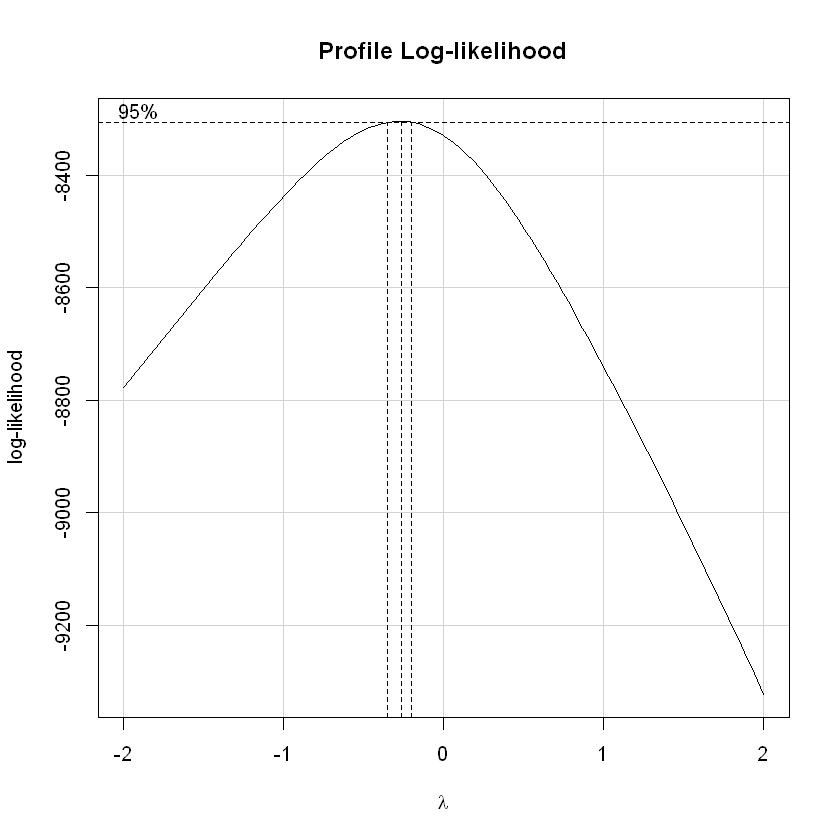

In [24]:
bc = boxCox(model5)

opt.lambda = bc$x[which.max(bc$y)]
cat('Optimal lambda: ', round(opt.lambda/0.5) * 0.5, '\n')

In [25]:
model6 <- lm( (1/sqrt(avg_ZHVI)) ~ RegionName + date + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless, data = train_new)
summary(model6)


Call:
lm(formula = (1/sqrt(avg_ZHVI)) ~ RegionName + date + Unsheltered.Homeless + 
    Overall.Homeless + Sheltered.ES.Homeless + Sheltered.TH.Homeless, 
    data = train_new)

Residuals:
       Min         1Q     Median         3Q        Max 
-2.904e-04 -4.396e-05 -1.400e-06  3.744e-05  3.678e-04 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2.053e-03  2.613e-05  78.552  < 2e-16 ***
RegionNameAL           7.432e-04  3.257e-05  22.822  < 2e-16 ***
RegionNameAR           8.506e-04  3.198e-05  26.596  < 2e-16 ***
RegionNameAZ           1.868e-04  3.523e-05   5.302 1.63e-07 ***
RegionNameCA          -1.062e-03  1.240e-04  -8.567  < 2e-16 ***
RegionNameCO          -1.719e-04  3.513e-05  -4.894 1.28e-06 ***
RegionNameCT           8.809e-05  3.210e-05   2.744 0.006255 ** 
RegionNameDE           1.248e-04  3.199e-05   3.902 0.000106 ***
RegionNameFL           1.412e-04  5.798e-05   2.436 0.015154 *  
RegionNameGA           4.765e-04 

Optimal Log was found to be -0.5, I did a 1/sqrt(avg_ZHVI) transformation. Considering a 0.05, or even a 0.1, threshold, none of the Homeless predictors show they are statistically significant. 

In [32]:
# checking for multicollinearity
threshold =  1/(1 - summary(model5)$r.squared)
cat('VIF threshold: ', max(10, threshold), '\n')
vif(model5)

VIF threshold:  14.84398 


,GVIF,Df,GVIF^(1/(2*Df))
RegionName,3.394629e+03,49,1.086497
date,1.919009e+00,12,1.027531
Unsheltered.Homeless,4.595101e+05,1,677.871724
Overall.Homeless,1.388634e+06,1,1178.403213
Sheltered.ES.Homeless,3.354075e+05,1,579.143797
Sheltered.TH.Homeless,3.010716e+04,1,173.514149


In [34]:
# checking for multicollinearity
cat('VIF threshold: ', max(10, 1/(1 - summary(model3)$r.squared)), '\n')
vif(model3)

VIF threshold:  10 


,GVIF,Df,GVIF^(1/(2*Df))
RegionName,2338.336978,49,1.082372
Overall.Homeless,26.596119,1,5.157143
Sheltered.ES.Homeless,42.610037,1,6.527636
Sheltered.TH.Homeless,8.605115,1,2.933448
Sheltered.SH.Homeless,8.198219,1,2.863253


For linearity, constant variance and normality assumption all models are rather similar. Model 2/3 does not have any multicollinearity, obviously this is once we take out Unsheltered.Homeless. While Model 4/5, has multicollinearity in all Homeless predictors. 

[1] "Cook's Distance threshold:  0.00615384615384615"
[1] "Number of Outliers:  44"


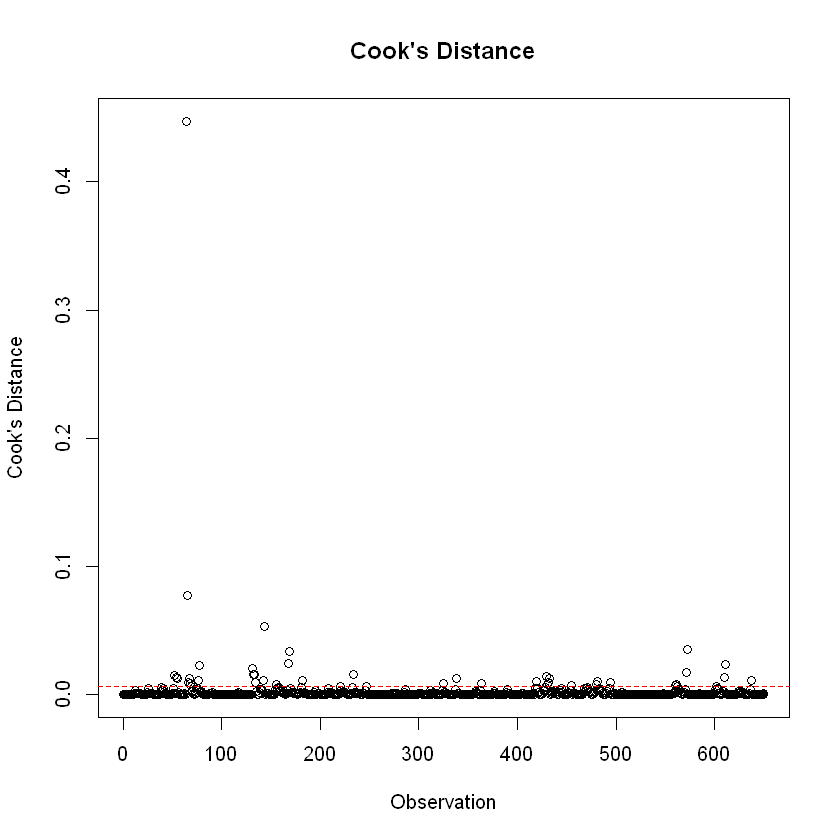

In [37]:
# checking for outliers
model_copy_cook <- cooks.distance(model5)
cook_n <- nrow(model5$model)
cook_threshold <- 4 / cook_n

plot(model_copy_cook, main = "Cook's Distance", ylab = "Cook's Distance", xlab = "Observation")
abline(h = cook_threshold, col = 'red', lty = 2)

print(paste("Cook's Distance threshold: ", cook_threshold))

outliers <- which(model_copy_cook > cook_threshold)

print(paste('Number of Outliers: ', length(outliers)))

between model 3 and model 5 there is only one more outlier seen in Model 4.

In [141]:
# print out the top 5 outliers
top_outliers <- order(model_copy_cook[outliers], decreasing = TRUE)[1:5]
outliers_rows <- train_new[outliers[top_outliers], ]
print(outliers_rows)

# A tibble: 5 × 9
  RegionName date  avg_ZHVI Overall.Homeless Sheltered.ES.Homeless
  <chr>      <chr>    <dbl>            <dbl>                 <dbl>
1 CA         2022   745788.           171521                 44553
2 HI         2022   823079.             5967                  1484
3 UT         2022   523455.             3557                  2219
4 ID         2022   470276.             1998                   811
5 CA         2010   307285.           123480                 23701
# ℹ 4 more variables: Sheltered.TH.Homeless <dbl>,
#   Sheltered.Total.Homeless <dbl>, Unsheltered.Homeless <dbl>,
#   Sheltered.SH.Homeless <dbl>


In [76]:
# prediction
prediction1 <- predict(model2, newdata = test_new)
comparison1 <- cbind(prediction1, test_new$avg_ZHVI)
cat('Adjusted R Squared model 2: ', summary(model2)$adj.r.squared, '\n')

prediction2 <- predict(model3, newdata = test_new)
comparison2 <- cbind(prediction2, test_new$avg_ZHVI)
cat('Adjusted R Squared model 3: ', summary(model3)$adj.r.squared, '\n')

cat('Adjusted R Squared model 4: ', summary(model4)$adj.r.squared, '\n')
cat('Adjusted R Squared model 5: ', summary(model5)$adj.r.squared, '\n')

Adjusted R Squared model 1:  0.8032681 
Adjusted R Squared model 2:  0.8032681 
Adjusted R Squared model 3:  0.9251346 
Adjusted R Squared model 4:  0.9251346 


In [61]:
# Ridge Regression with everything
x <- model.matrix(avg_ZHVI ~ RegionName + date + Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.SH.Homeless + Sheltered.TH.Homeless, data = df)[, -1]
y <- df$avg_ZHVI

ridge <- cv.glmnet(x, y, alpha = 0, nfolds = 10)
lambda <- ridge$lambda.min

ridge_model <- glmnet(x, y, alpha = 0, nlambda = 100)
coef(ridge_model, lambda)

68 x 1 sparse Matrix of class "dgCMatrix"
                                 s1
(Intercept)            2.228602e+05
RegionNameAL          -9.312381e+04
RegionNameAR          -1.041242e+05
RegionNameAZ           2.347545e+03
RegionNameCA           1.952423e+05
RegionNameCO           9.826397e+04
RegionNameCT           1.290841e+04
RegionNameDE           1.148546e+04
RegionNameFL          -2.839251e+04
RegionNameGA          -5.147633e+04
RegionNameHI           3.100526e+05
RegionNameIA          -9.476907e+04
RegionNameID           4.658669e+03
RegionNameIL          -5.642107e+04
RegionNameIN          -9.933524e+04
RegionNameKS          -1.011749e+05
RegionNameKY          -1.092945e+05
RegionNameLA          -7.648644e+04
RegionNameMA           1.232881e+05
RegionNameMD           4.566693e+04
RegionNameME          -1.873421e+04
RegionNameMI          -9.442230e+04
RegionNameMN          -1.593768e+04
RegionNameMO          -8.837196e+04
RegionNameMS          -1.127572e+05
RegionNameMT          

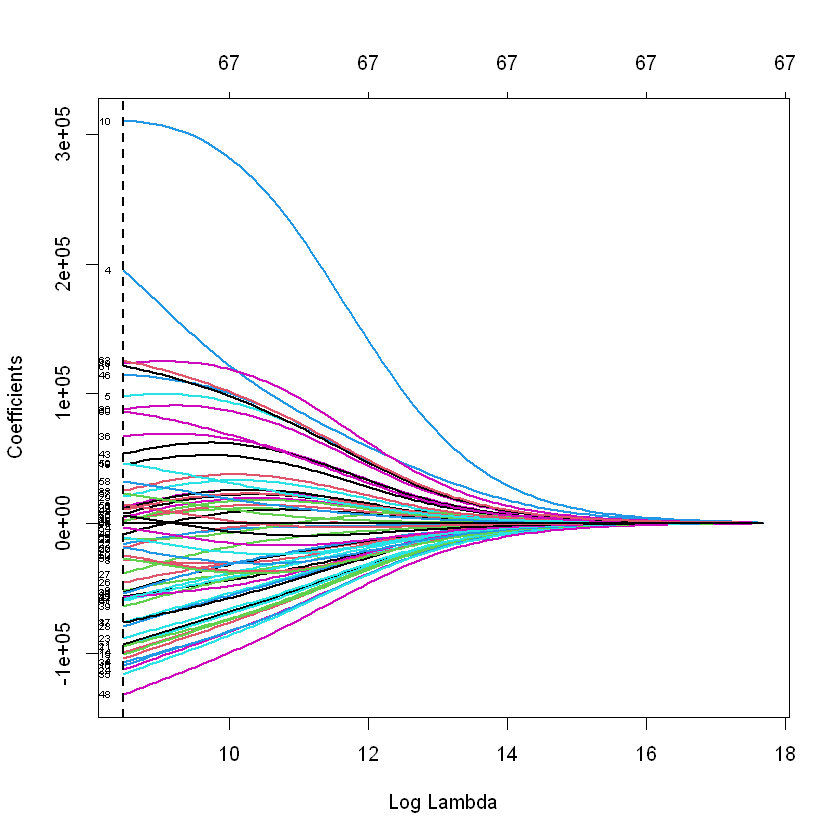

In [63]:
plot(ridge_model, xvar = 'lambda', label = TRUE, lwd = 2)
abline(v = log(lambda), col = 'black', lty = 2, lwd = 2)

In [65]:
# Ridge Regression with just homelessness
x2 <- model.matrix(avg_ZHVI ~ Unsheltered.Homeless + Overall.Homeless + Sheltered.ES.Homeless + Sheltered.SH.Homeless + Sheltered.TH.Homeless, data = df)[, -1]
y2 <- df$avg_ZHVI

ridge2 <- cv.glmnet(x2, y2, alpha = 0, nfolds = 10)
lambda2 <- ridge2$lambda.min

ridge_model2 <- glmnet(x2, y2, alpha = 0, nlambda = 100)
coef(ridge_model2, lambda2)

6 x 1 sparse Matrix of class "dgCMatrix"
                                 s1
(Intercept)            2.282548e+05
Unsheltered.Homeless   2.993449e+00
Overall.Homeless       1.156315e+00
Sheltered.ES.Homeless  1.825434e+00
Sheltered.SH.Homeless -1.333477e-01
Sheltered.TH.Homeless -1.387107e+01

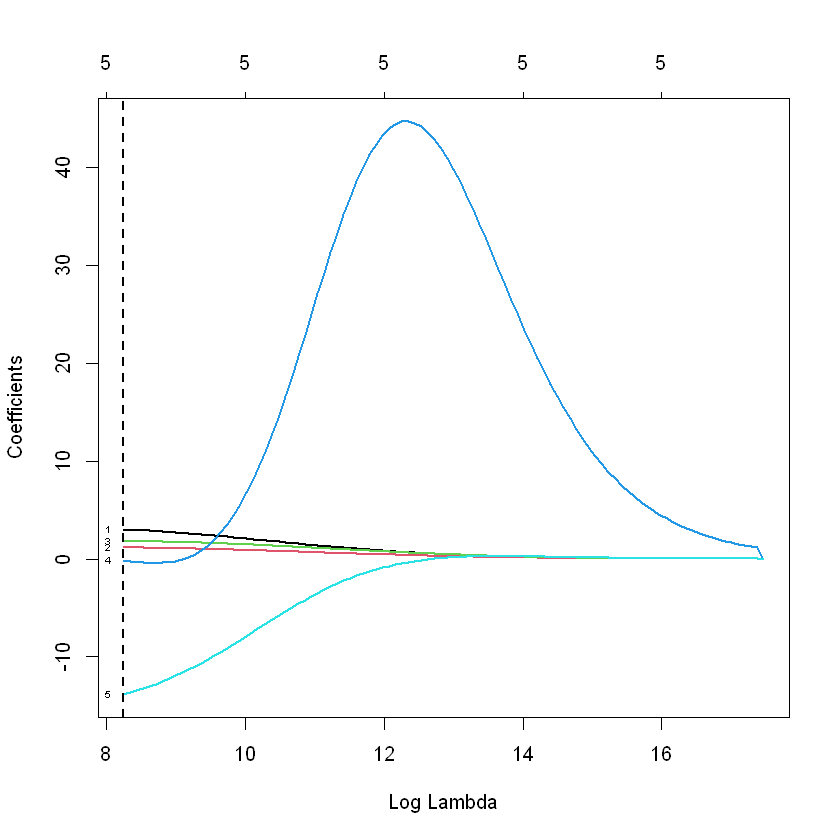

In [67]:
plot(ridge_model2, xvar = 'lambda', label = TRUE, lwd = 2)
abline(v = log(lambda2), col = 'black', lty = 2, lwd = 2)